## 2.1 tensorflow を使うためのモジュールをインストール


In [27]:
pip install flickrapi tensorflow

# **ステップ:5 npz ファイルを元に学習**


## 5.1 学習用データの準備

ローカルで作成した npz ファイルをクラウド上にアップロードした上で実行しましょう  
【※注意】移動させて直後だとエラーが出る場合があるので、少しだけ間を置いてから再度実行してみてください


In [39]:
import numpy as np                   # 数学的な操作や配列を扱うためのモジュール
from sklearn.model_selection import train_test_split  # データを分割するためのモジュール

# npzファイルから画像データを読み込む
photos = np.load('photos.npz')
# 画像データをxに代入
x = photos['x']
# ラベルデータをyに代入
y = photos['y']

## 5.2 データ前処理


In [40]:
# 画像の形状に関する情報
im_rows = 128       # 画像の行数
im_cols = 128       # 画像の列数
im_color = 3       # 画像の色の数(RGBなので3)
in_shape = (im_rows, im_cols, im_color)  # 画像の形状

# 画像データを適切な形状に変換
x = x.reshape(-1, im_rows, im_cols, im_color)
# 画像の各ピクセルの値を0から1の範囲にするために255で割る
x = x.astype('float32') / 255

## 5.3 学習用とテスト用に分ける


In [41]:
# データセットを訓練データとテストデータに分割
# test_size=0.2は、全データのうち20%をテストデータとして使うことを意味する
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

## **ステップ 6: モデルの作成**


## 6.1 CNN のモデル作成


In [42]:
import tensorflow
from tensorflow.keras import datasets, layers, models  # TensorFlowのライブラリをインポート
# CNN（畳み込みニューラルネットワーク）モデルを作成します。これは、画像を理解するための強力なツールです。
model = models.Sequential()

# 最初の層：128個のフィルターを持つ畳み込み層を追加します。これは、画像の特徴（例：エッジ、テクスチャ）を検出します。
# 3x3のサイズのフィルターを使用し、活性化関数としてReLU（ランプ関数）を使用します。
# input_shape=(128, 128, 3)は、入力画像が128x128ピクセルで3つのカラーチャンネル（RGB）を持っていることを意味します。
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(128, 128, 3)))

# 次の層：2x2のサイズで最大プーリング層を追加します。これは、画像のサイズを半分にし、重要な特徴だけを残します。
model.add(layers.MaxPooling2D((2, 2)))

# 畳み込み層をもう一度追加しますが、今回は64個のフィルターを使用します。
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# もう一度、最大プーリング層を追加します。
model.add(layers.MaxPooling2D((2, 2)))

# 64個のフィルターを持つもう一つの畳み込み層を追加します。
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# ここで、画像を1Dのリストに変換します。これは、全結合層（デンスレイヤー）に入力するための前処理です。
model.add(layers.Flatten())

# 64個のノードを持つ全結合層（デンスレイヤー）を追加し、ReLU活性化関数を使用します。
model.add(layers.Dense(64, activation='relu'))

# 最終層：2個のノードを持つ全結合層を追加します。これは現時点で２種類の分類を行っているからです
model.add(layers.Dense(3, activation='softmax'))

## 6.2 モデルのコンパイル


In [43]:
# モデルを訓練する前の準備
model.compile(
    optimizer='adam',  # 最適化手法はAdam（これはパラメータの調整方法）
    loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # 損失関数（予測と正解との差を計算）
    metrics=['accuracy']  # 正解率を計算する（どれだけ予測が当たっているか）
)

## 6.3 モデルの訓練


In [44]:
# モデルを訓練する（学習させる）
history = model.fit(
    x_train, y_train,  # 訓練データ（画像）と正解ラベル
    epochs=5,  # 全データを5回繰り返して学習する
    # 検証データ（こちらは学習には使わない。学習の進行状況を確認するためだけに使用）
    validation_data=(x_test, y_test)
)

# モデルを保存
model.save('my_model.keras')

Epoch 1/5
3/3 [==============================] - 2s 148ms/step - loss: 1.3391 - accuracy: 0.2917 - val_loss: 1.1153 - val_accuracy: 0.3750
Epoch 2/5
3/3 [==============================] - 0s 64ms/step - loss: 1.0975 - accuracy: 0.3542 - val_loss: 1.1021 - val_accuracy: 0.3333
Epoch 3/5
3/3 [==============================] - 0s 51ms/step - loss: 1.0892 - accuracy: 0.4271 - val_loss: 1.0968 - val_accuracy: 0.2917
Epoch 4/5
3/3 [==============================] - 0s 52ms/step - loss: 1.0299 - accuracy: 0.5312 - val_loss: 1.1004 - val_accuracy: 0.3333
Epoch 5/5
3/3 [==============================] - 0s 48ms/step - loss: 0.9856 - accuracy: 0.3542 - val_loss: 1.0819 - val_accuracy: 0.3333


---------------------------------------------------- round 2----------------------------------------------------

# **【課題 1】：正解率がまだ少し低いですが、何が原因だと考えられますか？**


## 回答：


# **ステップ:7 データの水増し**


## 7.1 データの水増し　やり方の確認


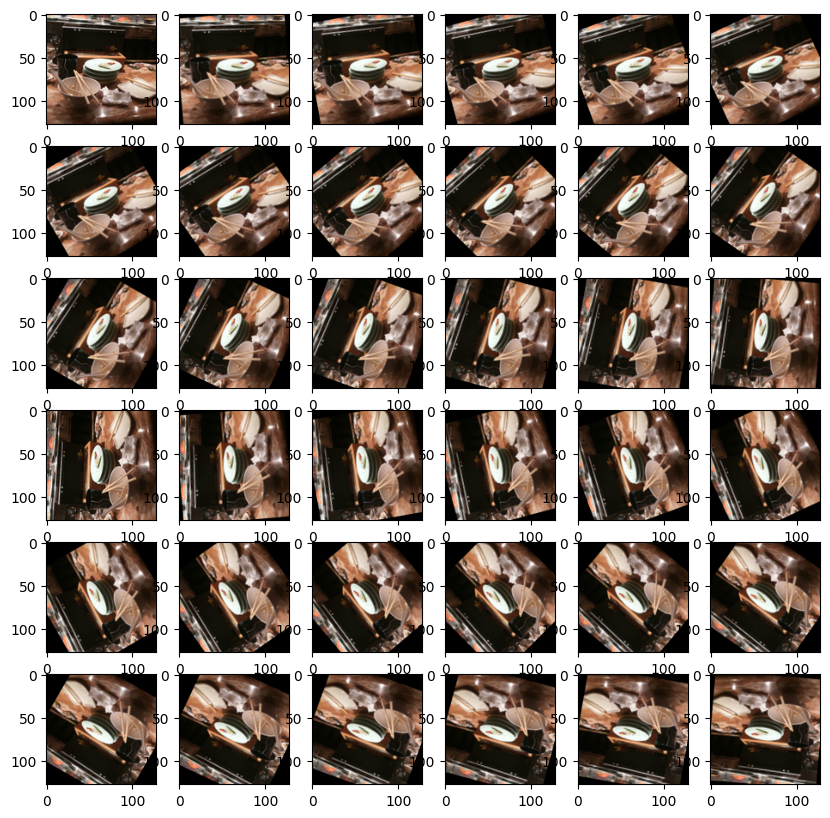

In [35]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

photo_size = 128
# 保存された画像データをロードします。
photos = np.load('photos.npz')
x = photos['x']
y = photos['y']

# 使いやすそうな写真を選択
img = x[8]

# 画像を表示するための領域を用意します。
plt.figure(figsize=(10, 10))

# 36枚の画像を表示します。
for i in range(36):
    # 6行6列で画像を表示します。
    plt.subplot(6, 6, i + 1)

    # 回転の中心を設定します（画像の中心）。
    center = (photo_size/2, photo_size/2)
    # 5度ずつ回転させます。
    angle = i * 5
    # サイズは変更しないので1.0にします。
    scale = 1.0

    # 回転させるための行列を作ります。
    mtx = cv2.getRotationMatrix2D(center, angle, scale)
    # 画像を回転させます。
    rotated_img = cv2.warpAffine(img, mtx, (photo_size, photo_size))

    # 回転させた画像を表示します。
    plt.imshow(rotated_img)

# 画像を表示します。
plt.show()

## 7.2 水増しを踏まえた上で学習を行う


In [36]:
import numpy as np                   # 数学的な操作や配列を扱うためのモジュール
from sklearn.model_selection import train_test_split  # データを分割するためのモジュール
import tensorflow
from tensorflow.keras import datasets, layers, models  # TensorFlowのライブラリをインポート
import cv2

# npzファイルから画像データを読み込む
photos = np.load('photos.npz')
# 画像データをxに代入
x = photos['x']
# ラベルデータをyに代入
y = photos['y']


# 画像の形状に関する情報
im_rows = 128       # 画像の行数
im_cols = 128       # 画像の列数
im_color = 3       # 画像の色の数(RGBなので3)
in_shape = (im_rows, im_cols, im_color)  # 画像の形状

# 画像データを適切な形状に変換
x = x.reshape(-1, im_rows, im_cols, im_color)
# 画像の各ピクセルの値を0から1の範囲にするために255で割る
x = x.astype('float32') / 255


# データセットを訓練データとテストデータに分割
# test_size=0.2は、全データのうち20%をテストデータとして使うことを意味する
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)


######### 水増し処理 ##########
photo_size = 128
# 学習データを水増しするための空のリストを準備します。
x_new = []
y_new = []

# 学習データの各画像について操作を行います。
for i, xi in enumerate(x_train):
    yi = y_train[i]

    # 各画像を-30度から30度の範囲で5度ずつ回転させます。
    for ang in range(-30, 30, 5):
        center = (photo_size/2 , photo_size/2 )  # 画像の中心を回転の中心点とします。
        mtx = cv2.getRotationMatrix2D(center, ang, 1.0)  # 指定した角度で回転させるための行列を作成します。
        rotated_img = cv2.warpAffine(xi, mtx, (photo_size , photo_size ))  # 作成した行列を使って画像を回転させます。

        x_new.append(rotated_img)  # 回転させた画像を新たな学習データとして追加します。
        y_new.append(yi)  # 対応するラベルも追加します。

        # さらに、画像を左右反転させます。
        flipped_img = cv2.flip(rotated_img, 1)  # 画像を左右に反転させます。

        x_new.append(flipped_img)  # 反転させた画像を新たな学習データとして追加します。
        y_new.append(yi)  # 対応するラベルも追加します。

# 水増し前と後のデータの量を表示します。
print(f"水増し前={len(y_train)}")
x_train = np.array(x_new)  # リストをNumPy配列に変換します。
y_train = np.array(y_new)  # リストをNumPy配列に変換します。
print(f"水増し後={len(y_train)}")  # 水増し後のデータの量を表示します。
######### 水増し処理 #########


# CNN（畳み込みニューラルネットワーク）モデルを作成します。これは、画像を理解するための強力なツールです。
model = models.Sequential()

# 最初の層：128個のフィルターを持つ畳み込み層を追加します。これは、画像の特徴（例：エッジ、テクスチャ）を検出します。
# 3x3のサイズのフィルターを使用し、活性化関数としてReLU（ランプ関数）を使用します。
# input_shape=(128, 128, 3)は、入力画像が128x128ピクセルで3つのカラーチャンネル（RGB）を持っていることを意味します。
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(128, 128, 3)))

# 次の層：2x2のサイズで最大プーリング層を追加します。これは、画像のサイズを半分にし、重要な特徴だけを残します。
model.add(layers.MaxPooling2D((2, 2)))

# 畳み込み層をもう一度追加しますが、今回は64個のフィルターを使用します。
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# もう一度、最大プーリング層を追加します。
model.add(layers.MaxPooling2D((2, 2)))

# 64個のフィルターを持つもう一つの畳み込み層を追加します。
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# ここで、画像を1Dのリストに変換します。これは、全結合層（デンスレイヤー）に入力するための前処理です。
model.add(layers.Flatten())

# 64個のノードを持つ全結合層（デンスレイヤー）を追加し、ReLU活性化関数を使用します。
model.add(layers.Dense(64, activation='relu'))

# 最終層：2個のノードを持つ全結合層を追加します。これは現時点で２種類の分類を行っているからです
model.add(layers.Dense(3, activation='softmax'))

# モデルを訓練する前の準備
model.compile(
    optimizer='adam',  # 最適化手法はAdam（これはパラメータの調整方法）
    loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # 損失関数（予測と正解との差を計算）
    metrics=['accuracy']  # 正解率を計算する（どれだけ予測が当たっているか）
)


# モデルを訓練する（学習させる）
history = model.fit(
    x_train, y_train,  # 訓練データ（画像）と正解ラベル

    epochs=5,  # 全データを10回繰り返して学習する

    # 検証データ（こちらは学習には使わない。学習の進行状況を確認するためだけに使用）
    validation_data=(x_test, y_test)
)

水増し前=96
水増し後=2304
Epoch 1/5
72/72 [==============================] - 4s 39ms/step - loss: 1.0134 - accuracy: 0.4809 - val_loss: 1.2944 - val_accuracy: 0.2917
Epoch 2/5
72/72 [==============================] - 3s 35ms/step - loss: 0.4729 - accuracy: 0.8177 - val_loss: 2.0597 - val_accuracy: 0.4167
Epoch 3/5
72/72 [==============================] - 2s 33ms/step - loss: 0.1106 - accuracy: 0.9674 - val_loss: 2.2806 - val_accuracy: 0.4167
Epoch 4/5
72/72 [==============================] - 2s 33ms/step - loss: 0.0214 - accuracy: 0.9957 - val_loss: 3.7228 - val_accuracy: 0.4583
Epoch 5/5
72/72 [==============================] - 2s 34ms/step - loss: 0.0117 - accuracy: 0.9970 - val_loss: 3.0585 - val_accuracy: 0.4583


## 7.3 学習済みのモデルを保存


In [37]:
# モデルを保存
model.save('my_model.keras')

生成されたモデルのファイルをローカルにダウンロードしておきましょう。


In [45]:
from google.colab import drive
drive.mount('/content/drive')

# Move the saved model to Google Drive
!cp my_model.keras "/content/drive/My Drive/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
